# Ground Projection

In [1]:
%load_ext autoreload
%autoreload 2

from dt_computer_vision.camera import CameraModel

from dt_computer_vision.camera.calibration.extrinsics.boards import CalibrationBoard8by6
from dt_computer_vision.ground_projection.rendering import debug_image
from dt_computer_vision_tests.line_detection_tests.test_detection import detect_color
from dt_computer_vision.ground_projection import GroundProjector

from dt_computer_vision.ground_projection.types import GroundPoint
from dt_computer_vision.camera import Pixel, NormalizedImagePoint

import os
import cv2
import numpy as np

import matplotlib.pyplot as plt

import matplotlib as mpl

mpl.rc("figure", dpi=200)


In [2]:
this_dir: str = os.path.abspath('')
assets_dir: str = os.path.join(this_dir, "..", "assets")
image_fpath: str = os.path.join(assets_dir, f"image0.jpg")
image_orig: np.ndarray = cv2.imread(image_fpath)
board = CalibrationBoard8by6

camera_properties = {
    "width": 640,
    "height": 480,
    "K": [[295.79606866959824, 0.0, 321.2621599038631],
          [0.0, 299.5389048862878, 241.73616515312332],
          [0.0, 0.0, 1.0]],
    "D": [-0.23543978771661125,
          0.03637781479419574,
          -0.0033069818601306755,
          -0.0012140708179525926,
          0.0],
    "P": [[201.14027404785156, 0.0, 319.5586620845679, 0.0],
          [0.0, 239.74398803710938, 237.60151004037834, 0.0],
          [0.0, 0.0, 1.0, 0.0]],
    # NOTE: this homography is computed in the 20-entrinsics-calibration jupyter notebook
    "H": [  [ 0.45484525,  0.33783685,  0.11218921],
            [-0.02801287,  1.02463437, -0.07835274],
            [-0.19216963,  3.63163831,  1.        ]]
}

assert image_orig.shape == (480, 640, 3)

In [3]:
# create camera
camera = CameraModel(**camera_properties)
projector = GroundProjector(camera)

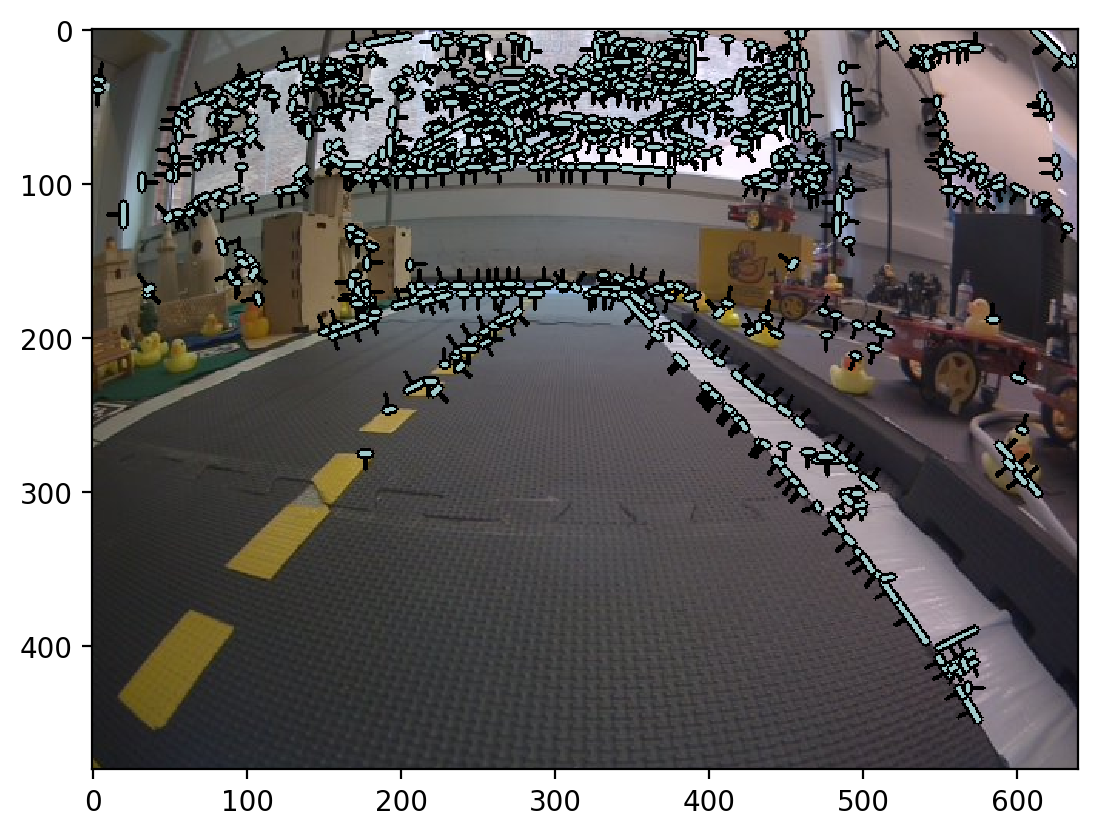

In [4]:
# detect segments
color: str = "white"
segments, image_w_detections = detect_color(image_orig, color)

# draw segments
image_w_detections = cv2.cvtColor(image_w_detections, cv2.COLOR_BGR2RGB)
plt.imshow(image_w_detections)

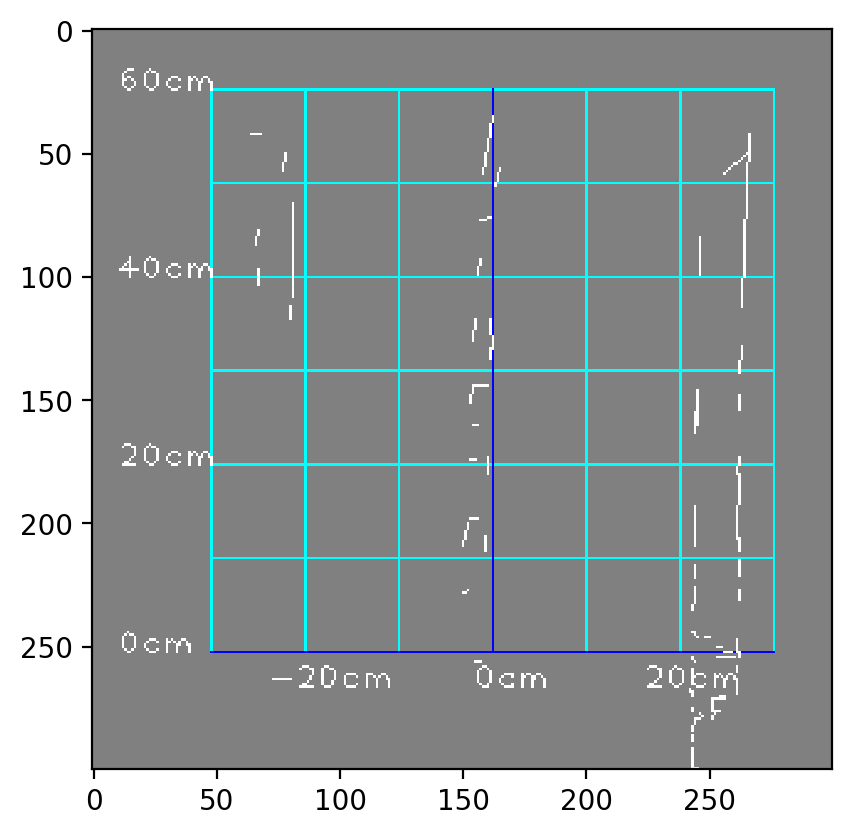

In [5]:
# project segments onto the ground plane
colored_segments = {
    (255, 255, 255): []
}

for segment in segments.lines:
    # distorted pixels
    p0: Pixel = Pixel(segment[0], segment[1])
    p1: Pixel = Pixel(segment[2], segment[3])
    #print(p0)
    # distorted pixels to rectified pixels
    p0_rect: Pixel = camera.rectifier.rectify_pixel(p0)
    p1_rect: Pixel = camera.rectifier.rectify_pixel(p1)
    #print(p0_rect)
    # rectified pixel to normalized coordinates
    p0_norm: NormalizedImagePoint = camera.pixel2vector(p0_rect)
    p1_norm: NormalizedImagePoint = camera.pixel2vector(p1_rect)
    #print(p0_norm)
    # project image point onto the ground plane
    p0_ground: GroundPoint = projector.vector2ground(p0_norm)
    p1_ground: GroundPoint = projector.vector2ground(p1_norm)
    
    
    # add grounded segment to output
    colored_segments[(255, 255, 255)].append((p0_ground, p1_ground))

image_w_projected_segments = debug_image(colored_segments, (300, 300), grid_size=6, s_segment_thickness=2, resolution=0.1)
image_w_projected_segments = cv2.cvtColor(image_w_projected_segments, cv2.COLOR_BGR2RGB)

plt.imshow(image_w_projected_segments)

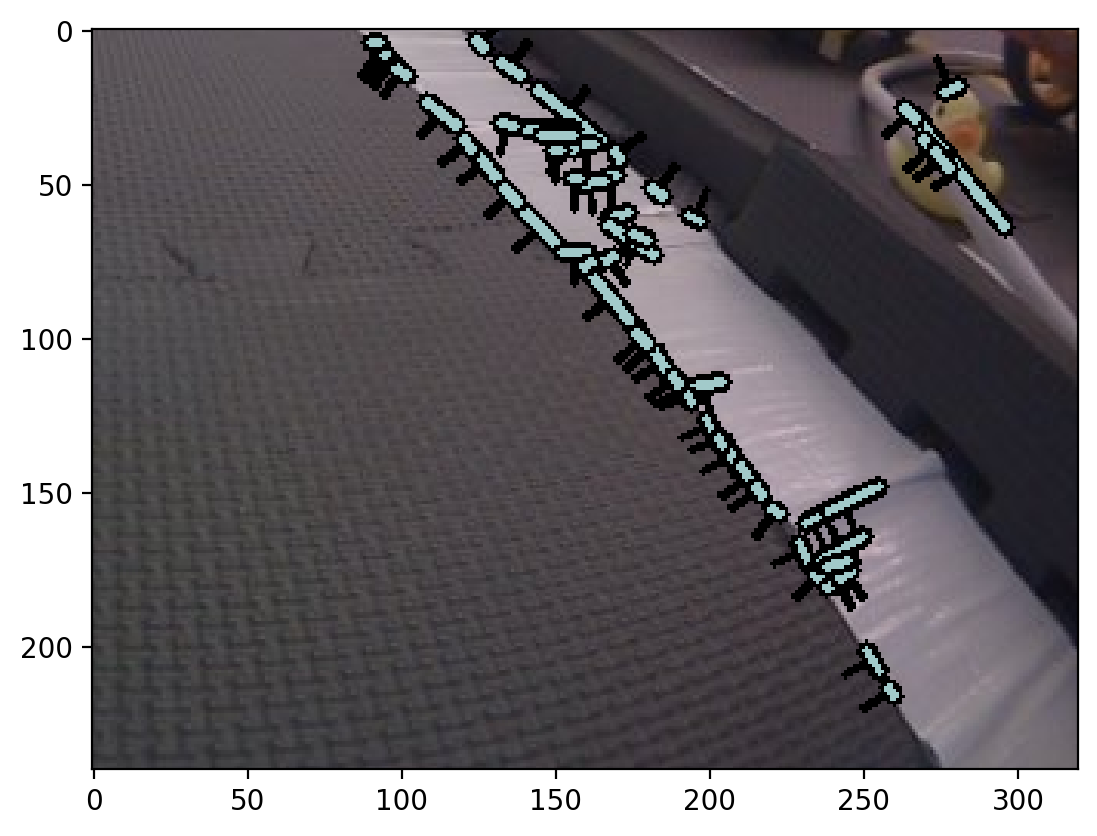

In [6]:
from copy import deepcopy

# define cropping
crop_x_amount = 0.5
crop_y_amount = 0.5

# create new camera parameters
crop_x = int(image_orig.shape[1] * crop_x_amount)
crop_y = int(image_orig.shape[0] * crop_y_amount)
camera_params_orig = deepcopy(camera_properties)
camera_params_cropped = deepcopy(camera_properties)
camera_params_cropped["K"][0][2] -= crop_x
camera_params_cropped["K"][1][2] -= crop_y

# TODO: this should be using the rectified cx, cy instead
camera_params_cropped["P"][0][2] -= crop_x
camera_params_cropped["P"][1][2] -= crop_y

# crop image
image_cropped = image_orig[crop_y:, crop_x:, :]
assert image_cropped.shape == (image_orig.shape[0] - crop_y, image_orig.shape[1] - crop_x, image_orig.shape[2])

# update camera
camera_cropped = CameraModel(**camera_params_cropped)
projector_cropped = GroundProjector(camera_cropped)

# detect segments
color: str = "white"
segments_cropped, image_w_detections_cropped = detect_color(image_cropped, color)

# draw segments
image_w_detections_cropped = cv2.cvtColor(image_w_detections_cropped, cv2.COLOR_BGR2RGB)
plt.imshow(image_w_detections_cropped)

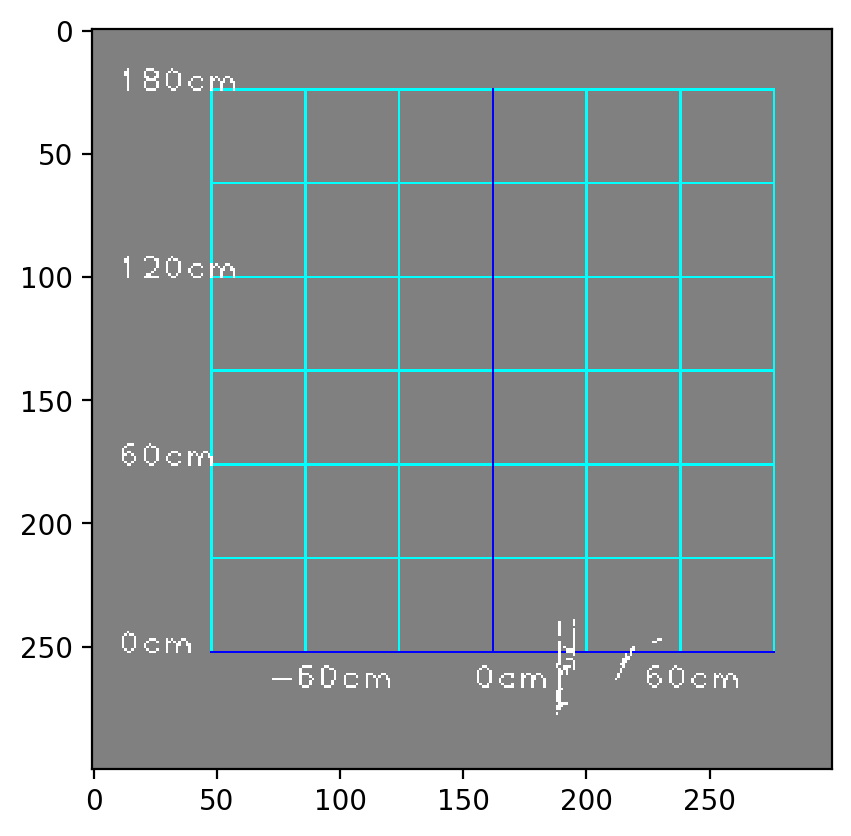

In [7]:
# project segments onto the ground plane
colored_segments_cropped = {
    (255, 255, 255): []
}

for segment in segments_cropped.lines:
    # distorted pixels
    p0: Pixel = Pixel(segment[0], segment[1])
    p1: Pixel = Pixel(segment[2], segment[3])
    #print(p0)
    # distorted pixels to rectified pixels
    p0_rect: Pixel = camera_cropped.rectifier.rectify_pixel(p0)
    p1_rect: Pixel = camera_cropped.rectifier.rectify_pixel(p1)
    #print(p0_rect)
    # rectified pixel to normalized coordinates
    p0_norm: NormalizedImagePoint = camera_cropped.pixel2vector(p0_rect)
    p1_norm: NormalizedImagePoint = camera_cropped.pixel2vector(p1_rect)
    #print(p0_norm)
    # project image point onto the ground plane
    p0_ground: GroundPoint = projector_cropped.vector2ground(p0_norm)
    p1_ground: GroundPoint = projector_cropped.vector2ground(p1_norm)
    # print(p0)
    # add grounded segment to output
    colored_segments_cropped[(255, 255, 255)].append((p0_ground, p1_ground))

image_w_projected_segments_cropped = debug_image(colored_segments_cropped, (300, 300), grid_size=6, s_segment_thickness=2)
image_w_projected_segments_cropped = cv2.cvtColor(image_w_projected_segments_cropped, cv2.COLOR_BGR2RGB)
plt.imshow(image_w_projected_segments_cropped)

# DD24 Ground Projection

In [8]:
# DD24 Ground Projection

import os
import cv2
import numpy as np

from dt_computer_vision.camera import CameraModel
from dt_computer_vision.camera.calibration.extrinsics.boards import CalibrationBoardDD24

this_dir: str = os.path.abspath("")
assets_dir: str = os.path.join(this_dir, "..", "assets")
image_fpath: str = os.path.join(assets_dir, "extrinsics/dd24/real-world/scenario0/image-0.png")
image: np.ndarray = cv2.imread(image_fpath)
board = CalibrationBoardDD24

# Load camera model from YAML file
yaml_file = os.path.join(
    assets_dir,
    "extrinsics",
    "dd24",
    "real-world",
    "scenario1",
    "calibration-intrinsic-dd24.yaml",
)

with open(yaml_file, "r") as file:
    yaml_content = file.read()
    camera = CameraModel.from_ros_calibration(yaml_content)

assert image.shape == (camera.height, camera.width, 3), f"Image shape: {image.shape}, Camera shape: {*camera.get_shape(), 3}"

In [9]:
# Load ground homography from YAML file
import os
import yaml

from dt_computer_vision.camera.homography import Homography
import numpy as np

this_dir: str = os.path.abspath("")
assets_dir: str = os.path.join(this_dir, "..", "assets")

yaml_file = os.path.join(
    assets_dir,
    "extrinsics",
    "dd24",
    "real-world",
    "scenario0",
    "homography.yaml",
)

with open(yaml_file, "r") as file:
    yaml_content = file.read()
    homography = yaml.safe_load(yaml_content)
    
H = Homography(np.array(homography["homography"]).reshape(3, 3))

print(H)

[[7.68649577e-02 4.80407934e-02 4.79735399e-02]
 [2.35921238e-04 1.98051018e-01 1.04001771e-01]
 [3.19667170e-02 9.15595543e-01 1.00000000e+00]]


In [10]:
from matplotlib import pyplot as plt

from dt_computer_vision.camera.homography import interpolate_homography
VIRTUAL_CAMERA_HEIGHT = 0.3

image = cv2.imread(os.path.join(assets_dir, "extrinsics/dd24/real-world/scenario0/image-0.png"))

R2 = np.eye(3)
tvec2 = np.array([0, 0.0, VIRTUAL_CAMERA_HEIGHT]).reshape(3, 1)

H_dt = interpolate_homography(H, tvec2, R2, camera)


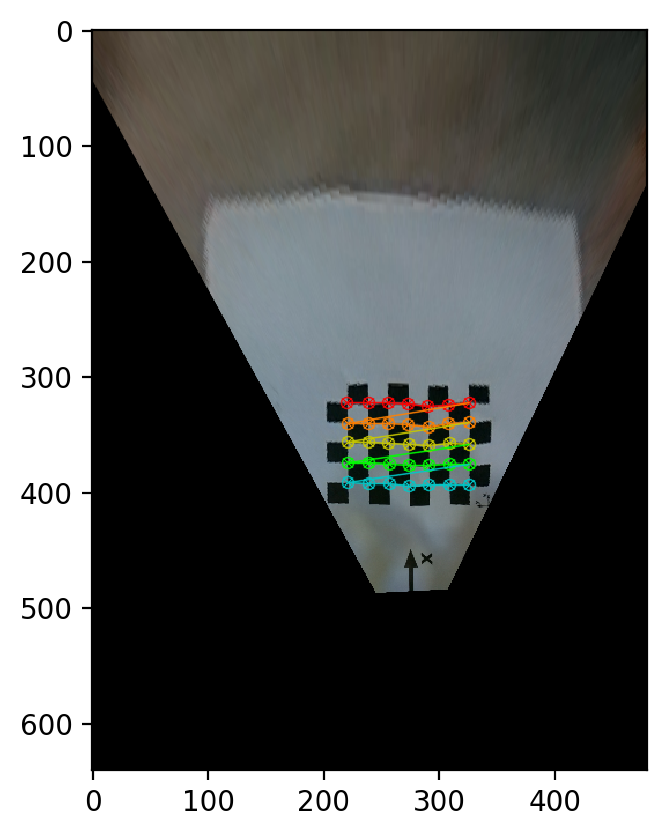

In [13]:
from dt_computer_vision.optical_flow.optical_flow import OpticalFlow
from typing import List
from dt_computer_vision.camera.calibration.extrinsics.chessboard import find_corners
from dt_computer_vision.camera.homography import Homography
from dt_computer_vision.camera.calibration.extrinsics.rendering import draw_corners

from dt_computer_vision.camera.calibration.extrinsics.boards import CalibrationBoardDD24
board = CalibrationBoardDD24

image_rect = camera.rectifier.rectify(image)

image_projected = cv2.warpPerspective(image_rect, H_dt, (camera.width, camera.height))
image_projected_rgb = cv2.cvtColor(image_projected, cv2.COLOR_BGR2RGB)

corners: List[Pixel] = find_corners(image_rect, board)

projected_corners = [OpticalFlow._project_pixel(p, H_dt) for p in corners]

image_w_corners = cv2.drawChessboardCorners(
    image_projected,
    (board.columns, board.rows),
    np.array([[p.x, p.y] for p in projected_corners], dtype=np.float32),
    True,
)
plt.imshow(cv2.cvtColor(image_w_corners, cv2.COLOR_BGR2RGB))